<a href="https://colab.research.google.com/github/pk2971/Customer-Lifetime-Value-Analysis-and-Prediction/blob/main/Customer_Lifetime_Value_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [109]:
df=pd.read_csv('RFMScores.csv')

In [110]:
df_user=pd.DataFrame(df.groupby('CustomerID')['Revenue'].sum().reset_index())

In [111]:
df['Revenue'].max()

279489.02

**Since there is no cost specified in the dataset, the Revenue becomes our LTV here in this project.**

In [112]:
#plot LTV histogram

import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

plot_data = [
    go.Histogram(
        x=df.query('Revenue<20000')['Revenue']
    )
]

plot_layout = go.Layout(
        title='Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

There are some negative and outlier revenue values based off the graph.

**We want to find the correlation between RFM scores and LTV/Revenue**

In [113]:
df_corr=pd.DataFrame()
df_corr['OverallScore']=pd.DataFrame(df['OverallScore'])
df_corr['Revenue']=pd.DataFrame(df['Revenue'])

In [114]:
corr=df_corr['Revenue'].corr(df_corr['OverallScore'])
corr

0.3386547571763006

<Figure size 1440x720 with 0 Axes>

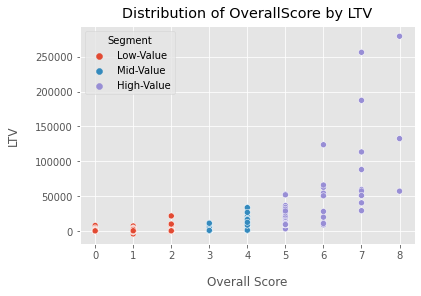

<Figure size 1440x720 with 0 Axes>

In [115]:
sns.scatterplot(x=df['OverallScore'],y=df['Revenue'],hue=df['Segment'])
plt.xlabel("Overall Score", labelpad=15)
plt.ylabel("LTV", labelpad=15)
plt.title("Distribution of OverallScore by LTV", y=1.013);
plt.figure(figsize=(20,10)) 


We can see that high RFM means high LTV. There is a positive correlation here



**We use regression to predict LTV**

We want to segment the LTV as Low LTV, Mid LTV and High LTV. We will once again perform this segmentation using K-Means clustering.

In [116]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(df[['Revenue']])
df['LTVCluster'] = kmeans.predict(df[['Revenue']])

def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final
df = order_cluster('LTVCluster', 'Revenue',df,True)

In [117]:
df.groupby('LTVCluster')['Revenue'].describe()
#Before removing outliers

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,4347.0,1440.838648,2473.463137,-4287.63,291.94,642.81,1574.285,30300.82
1,22.0,59696.842273,29287.039236,31300.08,37348.76,52287.28,61844.660,132572.62
2,3.0,241136.560000,47874.073443,187482.17,221960.33,256438.49,267963.755,279489.02


**We use the Zscore technique to remove the outliers.**

 We also remove all the negative revenue values in the data set.

In [118]:
df['zscore']=(df.Revenue-df.Revenue.mean())/df.Revenue.std()

In [119]:
df_no_outliers=pd.DataFrame(df[(df.zscore<4) & (df.Revenue>0)])
df_no_outliers.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,LTVCluster,zscore
0,17850.0,301,0,312,1,5288.63,0,1,Low-Value,0,0.412462
1,15808.0,305,0,210,1,3724.77,0,1,Low-Value,0,0.222197
2,13047.0,31,3,196,1,3079.10,0,4,Mid-Value,0,0.143642
3,12583.0,2,3,251,1,7187.34,0,4,Mid-Value,0,0.643467
4,14688.0,7,3,359,1,5107.38,0,4,Mid-Value,0,0.390411


In [120]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_no_outliers[['Revenue']])
df_no_outliers['LTVCluster'] = kmeans.predict(df_no_outliers[['Revenue']])

df_no_outliers = order_cluster('LTVCluster', 'Revenue',df_no_outliers,True)

In [121]:
df_no_outliers .groupby('LTVCluster')['Revenue'].describe()
#After removing ouliers

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,3839.0,827.525568,748.375758,1.776357e-15,270.695,562.41,1158.235,3246.091
1,422.0,5665.900071,2367.793601,3.250640e+03,3861.860,4870.90,6747.640,13375.870
2,41.0,21316.093902,6594.070192,1.361207e+04,16173.670,18793.41,26932.340,33805.690


2 is the best LTV with an average of arounf 21.3k and 0 is the worst LTV with mean of around 746.

**Feature engineering**

We convert some categorical columns to numerical and drop some irrelevant columns.

In [122]:
#dropping irrelevant columns
df_no_outliers =df_no_outliers.drop(['zscore'],axis=1)

In [123]:
df_pred=pd.get_dummies(df_no_outliers)

In [124]:
#Correlation matrix 
corr_matrix = df_pred.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster            1.000000
Revenue               0.831859
RevenueCluster        0.569859
FrequencyCluster      0.553269
Frequency             0.513987
Segment_High-Value    0.487630
OverallScore          0.423787
RecencyCluster        0.229723
Segment_Mid-Value     0.135181
CustomerID           -0.065807
Recency              -0.225465
Segment_Low-Value    -0.268534
Name: LTVCluster, dtype: float64

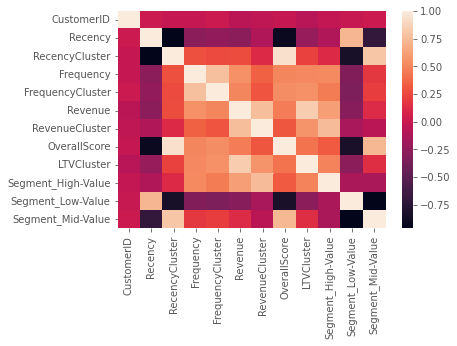

In [125]:
sns.heatmap(corr_matrix)


From the correlation visualizations we can see that Revenue, Frequency and RFM OverallScore will be helpful for the prediction.

In [126]:
#to check the data frame.
df_pred.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,LTVCluster,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,17850.0,301,0,312,1,5288.63,0,1,1,0,1,0
1,15808.0,305,0,210,1,3724.77,0,1,1,0,1,0
2,12583.0,2,3,251,1,7187.34,0,4,1,0,0,1
3,14688.0,7,3,359,1,5107.38,0,4,1,0,0,1
4,12431.0,35,3,240,1,6416.39,0,4,1,0,0,1


**Prediction model**

We are using XGBoost Classifier model. 

In [127]:
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [128]:
X = df_pred.drop(['LTVCluster','Revenue'],axis=1)
y = df_pred['LTVCluster']

#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)


In [129]:
ltv_xgb= xgb.XGBClassifier(max_depth=5, learning_rate=0.1,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)


In [130]:
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb.score(X_test[X_train.columns], y_test)))


Accuracy of XGB classifier on training set: 0.96
Accuracy of XGB classifier on test set: 0.88


In [131]:
#Prediction
from sklearn.metrics import classification_report
y_pred = ltv_xgb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       189
           1       0.45      0.20      0.28        25
           2       0.50      1.00      0.67         2

    accuracy                           0.88       216
   macro avg       0.62      0.72      0.63       216
weighted avg       0.85      0.88      0.86       216



The model identifies low LTV customers very accurately. Mid and high level LTV not too accurate.

There is also not a lot of data around mid and high LTV, we could redcuce the low LTV customers data or collect more of the high and mid LTV to have more data about them in the data set.